<a href="https://colab.research.google.com/github/workingbetter/Optimisation_Project_2/blob/main/Optimisation_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Maximising a Function

In [24]:
import random
import math

# Define the objective function to be optimized
def f(x, y, z):
    return (
        math.exp(math.cos(53 * z))
        + math.sin(43 * math.exp(y))
        + math.exp(math.sin(29 * x))
        + math.sin(67 * math.sin(z))
        + math.cos(math.cos(37 * y))
        - (2 * x ** 2 + y ** 2 + z ** 2) / 4
    )

# Random search optimization technique
def random_search(steps, range_x, range_y, range_z):
    # Randomly select a starting point within the given ranges
    xb = random.uniform(*range_x)
    yb = random.uniform(*range_y)
    zb = random.uniform(*range_z)
    # Evaluate the objective function at the starting point
    fbest = f(xb, yb, zb)

    # Iteratively generate random points and update the best point found
    for _ in range(steps):
        xn = random.uniform(*range_x)
        yn = random.uniform(*range_y)
        zn = random.uniform(*range_z)
        fnew = f(xn, yn, zn)

        # If a new best point is found, update the best point
        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    # Return the best point found and its objective function value
    return (xb, yb, zb), fbest

# Hill-climbing optimization technique
def hill_climbing(steps, sigma, range_x, range_y, range_z):
    # Randomly select a starting point within the given ranges
    xb = random.uniform(*range_x)
    yb = random.uniform(*range_y)
    zb = random.uniform(*range_z)
    # Evaluate the objective function at the starting point
    fbest = f(xb, yb, zb)

    # Iteratively generate new points around the current best point and update the best point found
    for _ in range(steps):
        xn = xb + random.gauss(0, sigma)
        yn = yb + random.gauss(0, sigma)
        zn = zb + random.gauss(0, sigma)
        fnew = f(xn, yn, zn)

        # If a new best point is found, update the best point
        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    # Return the best point found and its objective function value
    return (xb, yb, zb), fbest

# Set the number of runs and steps
num_runs = 50
num_steps = 10000
range_x = (-1, 1)
range_y = (-1, 1)
range_z = (-1, 1)
sigmas = [0.001, 0.01, 0.1]

# Run both algorithms multiple times and collect results
random_search_results = []
hill_climbing_results = []

# Run both optimization algorithms for the specified number of runs and sigma values
for _ in range(num_runs):
    # Perform random search and store the results in random_search_results list
    random_search_results.append(random_search(num_steps, range_x, range_y, range_z))

    # Perform hill-climbing for each sigma value and store the results in hill_climbing_results list
    for sigma in sigmas:
        hill_climbing_result = hill_climbing(num_steps, sigma, range_x, range_y, range_z)
        hill_climbing_results.append((sigma, hill_climbing_result[0], hill_climbing_result[1]))

# Find and print the maximum values for both algorithms
random_search_max = max(random_search_results, key=lambda x: x[1])

# Print the results of the random search algorithm
print("Results:")
print(f"Number of runs: {num_runs}")
print(f"Number of steps: {num_steps}")
print(f"Search space: x = {range_x}, y = {range_y}, z = {range_z}\n")

print("Random search:")
print(f"Parameters: num_runs = {num_runs}, num_steps = {num_steps}")
print("Maximum value:", random_search_max[1])
print("Best solution: x =", random_search_max[0][0], ", y =", random_search_max[0][1], ", z =", random_search_max[0][2], "\n")

# Find the maximum objective function value and corresponding best solution for the hill-climbing algorithm
hill_climbing_max = max(hill_climbing_results, key=lambda x: x[2])

# Print the results of the hill-climbing algorithm
print("Hill climbing:")
print(f"Parameters: num_runs = {num_runs}, num_steps = {num_steps}")
print(f"Sigma values used: {sigmas}")
print(f"Max value obtained on sigma: {hill_climbing_max[0]}")
print("Maximum value:", hill_climbing_max[2])
print(f"Best solution: x = {hill_climbing_max[1][0]}, y = {hill_climbing_max[1][1]}, z = {hill_climbing_max[1][2]}")


Results:
Number of runs: 50
Number of steps: 10000
Search space: x = (-1, 1), y = (-1, 1), z = (-1, 1)

Random search:
Parameters: num_runs = 50, num_steps = 10000
Maximum value: 8.286619495439767
Best solution: x = 0.2717197059703995 , y = 0.2966188868629911 , z = -0.3560973003441079 

Hill climbing:
Parameters: num_runs = 50, num_steps = 10000
Sigma values used: [0.001, 0.01, 0.1]
Max value obtained on sigma: 0.001
Maximum value: 8.399260345989832
Best solution: x = 0.05418281995325058, y = 0.3000948756251535, z = 0.11810389970609121


# Part 2: Distribution Network

Generation 0: Cost 934.7907843980157
Generation 50: Cost 839.4156339109074
Generation 100: Cost 839.4156339109074
Generation 150: Cost 838.7745647551939
Generation 200: Cost 838.7745647551939
Generation 250: Cost 838.7745647551939
Generation 300: Cost 838.7745647551939
Generation 350: Cost 838.7745647551939
Generation 400: Cost 838.7745647551939
Generation 450: Cost 838.7745647551939
Best Delivery Strategy:
W1: 22, 2, 10, 21, 12, 11, 19, 5, 13, 18, 1, 7, 9, 6
W2: 3, 4, 20, 17, 14, 16, 8, 15, 23

Vehicle Requirements:
W1: 0 vans, 1 lorries
W2: 3 vans, 0 lorries

Routes:
W1 -> lorry -> 18, 1, 22, 21, 10, 2, 5, 11, 6, 9, 19, 13, 12, 7 -> W1 (Distance: 262.40)
W2 -> van -> 3, 20, 4, 17 -> W2 (Distance: 169.28)
W2 -> van -> 15, 16, 14, 8 -> W2 (Distance: 131.50)
W2 -> van -> 23 -> W2 (Distance: 13.20)

Total Cost: £838.7745647551939

Plotting Routes:


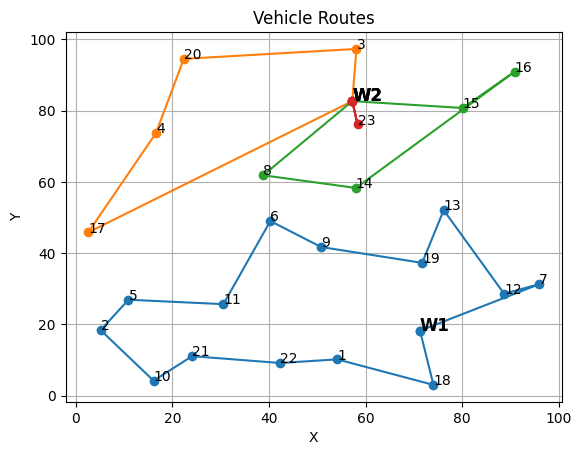

In [2]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from itertools import product

# Constants
WAREHOUSES = ['W1', 'W2']
STORES = [i for i in range(1, 24)]
POPULATION_SIZE = 100
GENERATIONS = 500
MUTATION_RATE = 0.1
VAN_CAPACITY = 4
LORRY_CAPACITY = 16
VAN_COST = 1
LORRY_COST = 2

# New constants
DISTANCE_PENALTY_FACTOR = 0.1
SWAP_MUTATION_RATE = 0.1
MOVE_MUTATION_RATE = 0.1

# Location data
LOCATIONS = {
    1: (54.13917237, 10.16301447),
    2: (5.163117855, 18.37136899),
    3: (58.10773412, 97.325872),
    4: (16.60663876, 73.67529068),
    5: (10.92151473, 26.90262604),
    6: (40.2830426, 49.00596112),
    7: (95.90679501, 31.25379214),
    8: (38.80688537, 61.84963412),
    9: (50.77362816, 41.71229884),
    10: (16.12104517, 4.174152112),
    11: (30.57252604, 25.66416139),
    12: (88.65418483, 28.60340585),
    13: (76.15833298, 52.06010201),
    14: (57.99079029, 58.29016932),
    15: (80.11801005, 80.74242101),
    16: (90.87902761, 90.97690565),
    17: (2.587207522, 45.80849397),
    18: (74.04980053, 2.986131158),
    19: (71.70911665, 37.25817058),
    20: (22.37191714, 94.53074723),
    21: (24.10112206, 11.06658123),
    22: (42.27800052, 9.141860385),
    23: (58.3280586, 76.15907608),
    'W1': (71.25359844, 18.21268482),
    'W2': (57.24219473, 82.66876117),
}

# The `distance` function calculates the Euclidean distance between two locations.
def distance(a, b):
    return math.sqrt((LOCATIONS[a][0] - LOCATIONS[b][0]) ** 2 + (LOCATIONS[a][1] - LOCATIONS[b][1]) ** 2)

# The `create_individual` function creates a new individual with random assignments of stores to warehouses.
def create_individual():
    individual = {warehouse: [] for warehouse in WAREHOUSES}
    
    for store in STORES:
        # Assign stores to the nearest warehouse.
        nearest_warehouse = min(WAREHOUSES, key=lambda warehouse: distance(warehouse, store))
        individual[nearest_warehouse].append(store)
    
    return individual

# The `calculate_penalty` function calculates the penalty for stores that are too far apart within a warehouse.
def calculate_penalty(individual):
    penalty = 0
    for warehouse, stores in individual.items():
        for i in range(len(stores)):
            for j in range(i+1, len(stores)):
                penalty += distance(stores[i], stores[j])
    return penalty * DISTANCE_PENALTY_FACTOR

# The `calculate_fitness` function calculates the fitness of an individual, which is a combination of cost and penalty.
def calculate_fitness(individual):
    cost = calculate_cost(individual)
    penalty = calculate_penalty(individual)
    warehouse_distance_penalty = sum(distance(warehouse, store) for warehouse, stores in individual.items() for store in stores)
    return 1 / (cost + penalty + warehouse_distance_penalty)

# The `mutate_swap` function applies the swap mutation operator to an individual.
def mutate_swap(individual):
    for warehouse, stores in individual.items():
        if random.random() < SWAP_MUTATION_RATE:
            if len(stores) > 1:
                # Choose two stores to swap.
                a, b = random.sample(range(len(stores)), 2)
                stores[a], stores[b] = stores[b], stores[a]

    return individual

# The `mutate_move` function applies the move mutation operator to an individual.
def mutate_move(individual):
    # Apply the mutation with probability `MOVE_MUTATION_RATE`.
    if random.random() < MOVE_MUTATION_RATE:
        # Choose two warehouses to move a store from one to the other.
        source_warehouse, target_warehouse = random.sample(WAREHOUSES, 2)

        # Check if the source warehouse has any stores to move.
        if len(individual[source_warehouse]) > 0:
            # Choose a store to move.
            moving_store = random.choice(individual[source_warehouse])
            individual[source_warehouse].remove(moving_store)
            individual[target_warehouse].append(moving_store)

    return individual

# The `mutate` function applies the swap and move mutation operators to an individual.
def mutate(individual):
    # Apply the swap mutation operator.
    individual = mutate_swap(individual)

    # Apply the move mutation operator.
    individual = mutate_move(individual)

    return individual

# The `calculate_cost` function calculates the total cost of an individual by adding up the cost of each route.
def calculate_cost(individual):
    # Get the summary of routes for the individual.
    summary = route_summary(individual)

    # Initialize the total cost to 0.
    total_cost = 0

    # Add up the cost of each route in the summary.
    for warehouse, details in summary.items():
        for _, _, _, route_cost in details['routes']:
            total_cost += route_cost

    return total_cost
# The `ordered_crossover` function performs ordered crossover on two parents for a given warehouse.
def ordered_crossover(parent1, parent2, warehouse):
    # If one of the parents has no stores for the given warehouse, return the other parent's stores.
    if not parent1[warehouse] or not parent2[warehouse]:
        return parent1[warehouse] if parent1[warehouse] else parent2[warehouse]

    # If one of the parents has only one store for the given warehouse, return the other parent's stores.
    if len(parent1[warehouse]) <= 1:
        return parent2[warehouse]
    if len(parent2[warehouse]) <= 1:
        return parent1[warehouse]

    # Find two random crossover points
    start, end = sorted(random.sample(range(len(parent1[warehouse])), 2))

    # Initialize child list with None values
    child = [None] * len(parent1[warehouse])

    # Copy stores between the crossover points from parent1 to the child
    child[start:end+1] = parent1[warehouse][start:end+1]

    # Fill the rest of the child with stores from parent2 that are not already in the child
    p2_stores = [store for store in parent2[warehouse] if store not in child and store is not None]
    for i in chain(range(start), range(end+1, len(child))):
        if len(p2_stores) > 0:
            child[i] = p2_stores.pop(0)
        else:
            break

    # Filter out None values from the child list
    child = list(filter(None, child))

    return child

def crossover(parent1, parent2):
    child = {}

    # Perform ordered crossover for each warehouse.
    for warehouse in WAREHOUSES:
        child[warehouse] = ordered_crossover(parent1, parent2, warehouse)

    return child

# The `is_valid_individual` function checks whether an individual is valid, i.e., whether it contains all stores exactly once.
def is_valid_individual(individual):
    # Get the set of all stores and the set of stores in the individual.
    all_stores = set(STORES)
    individual_stores = set(chain.from_iterable(individual.values()))

    # Check if the sets are equal.
    return all_stores == individual_stores
def genetic_algorithm():
    # Initialize the population based on the improved `create_individual` function.
    population = [create_individual() for _ in range(POPULATION_SIZE)]

    for generation in range(GENERATIONS):
        # Calculate the cost and fitness of each individual in the population.
        population_costs = [calculate_cost(ind) for ind in population]
        population_fitness = [calculate_fitness(ind) for ind in population]

        # Print the cost of the best individual in the population every 50 generations.
        if generation % 50 == 0:
            best_individual_index = population_costs.index(min(population_costs))
            print(f"Generation {generation}: Cost {population_costs[best_individual_index]}")

        # Create a new population.
        new_population = []

        # Elitism: add the best individual to the new population.
        best_individual_index = population_costs.index(min(population_costs))
        new_population.append(population[best_individual_index])

        # Tournament selection: select two individuals at random and choose the one with the higher fitness.
        while len(new_population) < POPULATION_SIZE:
            tournament_indices = random.sample(range(POPULATION_SIZE), 2)
            tournament_fitness = [population_fitness[i] for i in tournament_indices]
            selected_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
            selected_individual = population[selected_index]

            # Create a child through crossover and mutation.
            child = crossover(selected_individual, selected_individual)
            child = mutate(child)

            # Check if the child is a valid individual before adding it to the new population.
            if is_valid_individual(child):
                new_population.append(child)

        # Update the population.
        population = new_population

    return population[0]


# The `nearest_neighbor_route` function returns the nearest neighbor route starting from a warehouse.
def nearest_neighbor_route(warehouse, stores):
    # Make a copy of the `stores` list to avoid modifying the original.
    remaining_stores = stores.copy()

    # Start at the warehouse.
    current_store = warehouse

    # Initialize the route list.
    route = []

    # Find the nearest store and add it to the route until all stores are visited.
    while remaining_stores:
        nearest_store = min(remaining_stores, key=lambda store: distance(current_store, store))
        route.append(nearest_store)
        remaining_stores.remove(nearest_store)
        current_store = nearest_store

    return route

# The `route_summary` function calculates the routes and costs for each warehouse in the individual.
def route_summary(individual):
    summary = {}

    # Find the warehouse with the most stores
    warehouse_most_stores = max(individual, key=lambda w: len(individual[w]))

    for warehouse, stores in individual.items():
        routes = []

        # Assign one lorry to the warehouse with the most stores
        if warehouse == warehouse_most_stores:
            route_stores = nearest_neighbor_route(warehouse, stores[:LORRY_CAPACITY])
            lorry_cost = LORRY_COST * (distance(warehouse, route_stores[0]) + distance(route_stores[-1], warehouse))
            for j in range(len(route_stores) - 1):
                lorry_cost += LORRY_COST * distance(route_stores[j], route_stores[j + 1])

            routes.append((warehouse, 'lorry', route_stores, lorry_cost))
            stores = stores[LORRY_CAPACITY:]

        # Calculate van routes
        for i in range(0, len(stores), VAN_CAPACITY):
            route_stores = nearest_neighbor_route(warehouse, stores[i: i + VAN_CAPACITY])
            van_cost = VAN_COST * (distance(warehouse, route_stores[0]) + distance(route_stores[-1], warehouse))
            for j in range(len(route_stores) - 1):
                van_cost += VAN_COST * distance(route_stores[j], route_stores[j + 1])

            routes.append((warehouse, 'van', route_stores, van_cost))

        summary[warehouse] = {
            'routes': routes,
        }

    return summary


# The `calculate_route_distance` function calculates the total distance traveled for a given route.
def calculate_route_distance(warehouse, route_stores):
    route_distance = distance(warehouse, route_stores[0]) + distance(route_stores[-1], warehouse)
    for j in range(len(route_stores) - 1):
        route_distance += distance(route_stores[j], route_stores[j + 1])
    return route_distance


# The `plot_routes` function plots the routes of the vehicles.
def plot_routes(summary):
    for warehouse, details in summary.items():
        for _, vehicle_type, route_stores, _ in details['routes']:
            x = [LOCATIONS[warehouse][0]] + [LOCATIONS[store][0] for store in route_stores] + [LOCATIONS[warehouse][0]]
            y = [LOCATIONS[warehouse][1]] + [LOCATIONS[store][1] for store in route_stores] + [LOCATIONS[warehouse][1]]

            plt.plot(x, y, marker='o')
            plt.text(LOCATIONS[warehouse][0], LOCATIONS[warehouse][1], warehouse, fontsize=12, fontweight='bold')
            for store in route_stores:
                plt.text(LOCATIONS[store][0], LOCATIONS[store][1], str(store), fontsize=10)

    plt.title("Vehicle Routes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

# This function is the main function of the program, where the genetic algorithm is run, the results are printed, and the routes are plotted.
def main():
    # Run the genetic algorithm and get the best individual, total cost, and summary of the routes.
    best_individual = genetic_algorithm()
    total_cost = calculate_cost(best_individual)
    summary = route_summary(best_individual)

    # Print the best delivery strategy for each warehouse
    print("Best Delivery Strategy:")
    for warehouse, stores in best_individual.items():
        print(f"{warehouse}: {', '.join(map(str, stores))}")
    
    # Print the number of vehicles required for each warehouse
    print("\nVehicle Requirements:")
    for warehouse, details in summary.items():
        van_count = sum(1 for _, vehicle_type, _, _ in details['routes'] if vehicle_type == 'van')
        lorry_count = sum(1 for _, vehicle_type, _, _ in details['routes'] if vehicle_type == 'lorry')
        print(f"{warehouse}: {van_count} vans, {lorry_count} lorries")

    # Print the details of each route, including the distance
    print("\nRoutes:")
    for warehouse, details in summary.items():
        for _, vehicle_type, route_stores, _ in details['routes']:
            route_distance = calculate_route_distance(warehouse, route_stores)
            print(f"{warehouse} -> {vehicle_type} -> {', '.join(map(str, route_stores))} -> {warehouse} (Distance: {route_distance:.2f})")

    # Print the total cost of the delivery
    print(f"\nTotal Cost: £{total_cost}")
    
    # Plot the routes using matplotlib
    print("\nPlotting Routes:")
    plot_routes(summary)

main()



# Part 2.1

# Part 3

In [57]:
import random

# Some are approximated from Tesco and Simulated data for foods with nutrient values and cost £
foods = {
    'apple': {'cost': 0.5, 'protein': 0.3, 'fat': 0.2, 'carbs': 14, 'vitamin_c': 4.6},
    'chicken': {'cost': 1.5, 'protein': 27, 'fat': 5, 'carbs': 0, 'vitamin_c': 0},
    'rice': {'cost': 0.2, 'protein': 2.7, 'fat': 0.5, 'carbs': 45, 'vitamin_c': 0},
    'broccoli': {'cost': 0.9, 'protein': 2.8, 'fat': 0.3, 'carbs': 7, 'vitamin_c': 89.2},
    'milk': {'cost': 0.9, 'protein': 8, 'fat': 5, 'carbs': 12, 'vitamin_c': 0},
    'bread': {'cost': 0.2, 'protein': 2.2, 'fat': 1, 'carbs': 12, 'vitamin_c': 0},
    'egg': {'cost': 0.3, 'protein': 6.3, 'fat': 4.8, 'carbs': 0.6, 'vitamin_c': 0},
    'spinach': {'cost': 0.5, 'protein': 2.9, 'fat': 0.4, 'carbs': 3.6, 'vitamin_c': 28.1},
    'yogurt': {'cost': 0.8, 'protein': 10, 'fat': 3.3, 'carbs': 7.7, 'vitamin_c': 0},
    'beans': {'cost': 0.3, 'protein': 7.5, 'fat': 0.5, 'carbs': 21, 'vitamin_c': 0}
}


# Nutritional requirements for a day
daily_requirements = {
    'protein': 50,
    'fat': 44,
    'carbs': 130,
    'vitamin_c': 75
}

# Hill climbing algorithm parameters
num_iterations = 50000
step_size = 0.1


def generate_initial_solution(foods):
    """Generate an initial solution by setting random amounts for each food."""
    solution = {}
    for food in foods:
        # Set a random amount for each food between 0 and 5
        solution[food] = random.uniform(0, 5)
    return solution

def get_cost(solution, foods):
    """Calculate the total cost of the solution."""
    # Calculate the cost of each food in the solution and sum them up
    return sum([solution[food] * foods[food]['cost'] for food in solution])

def get_nutrients(solution, foods):
    """Calculate the total nutrients of the solution."""
    nutrients = {}
    for food in solution:
        for nutrient in foods[food]:
            # Check if the nutrient is not the cost and add it to the total
            if nutrient != 'cost':
                if nutrient not in nutrients:
                    nutrients[nutrient] = 0
                nutrients[nutrient] += solution[food] * foods[food][nutrient]
    return nutrients

def meets_requirements(nutrients, requirements):
    """Check if the solution meets the daily nutritional requirements."""
    for nutrient in requirements:
        # Check if the nutrient requirement is met for the solution
        if nutrients[nutrient] < requirements[nutrient]:
            return False
    return True

def hill_climb(foods, requirements, num_iterations, step_size):
    """Optimize the meal plan using the hill climbing algorithm."""
    current_solution = generate_initial_solution(foods)
    current_cost = get_cost(current_solution, foods)

    for _ in range(num_iterations):
        new_solution = current_solution.copy()

        # Modify the current solution slightly by adding/subtracting a small step
        food_to_modify = random.choice(list(foods.keys()))
        new_solution[food_to_modify] += random.uniform(-step_size, step_size)
        new_solution[food_to_modify] = max(0, new_solution[food_to_modify])

        # Calculate the new solution's cost and nutrients
        new_cost = get_cost(new_solution, foods)
        new_nutrients = get_nutrients(new_solution, foods)

        # If the new solution is better and meets requirements, update the current solution
        if new_cost < current_cost and meets_requirements(new_nutrients, requirements):
            current_solution = new_solution
            current_cost = new_cost

    return current_solution, current_cost

# Main function to run the optimization
def main():
    # Run the hill climbing algorithm to find an optimal meal plan
    optimal_solution, optimal_cost = hill_climb(foods, daily_requirements, num_iterations, step_size)

    # Round the servings to the nearest whole number
    rounded_optimal_solution = {food: round(amount) for food, amount in optimal_solution.items()}

    # Calculate the cost and nutrients of the rounded solution
    rounded_optimal_cost = get_cost(rounded_optimal_solution, foods)
    rounded_optimal_nutrients = get_nutrients(rounded_optimal_solution, foods)

    # Print the results
    print("Optimal Weekly meal plan (Cost Sum £):")
    for food, amount in rounded_optimal_solution.items():
        if amount > 0:  # Only print if servings are greater than 0
            total_cost = foods[food]['cost'] * amount
            print(f"{food.capitalize()}: {amount} servings ( £{total_cost:.2f})")

    print("\nTotal cost: £{:.2f}".format(rounded_optimal_cost)) 

    print("\nNutrients:")
    for nutrient, amount in rounded_optimal_nutrients.items():
        print(f"{nutrient.capitalize()}: {amount:.1f}")


if __name__ == "__main__":
    main()



Optimal Weekly meal plan (Cost Sum £):
Apple: 3 servings ( £1.50)
Rice: 1 servings ( £0.20)
Broccoli: 3 servings ( £2.70)
Milk: 2 servings ( £1.80)
Bread: 1 servings ( £0.20)
Egg: 4 servings ( £1.20)
Spinach: 1 servings ( £0.50)
Yogurt: 2 servings ( £1.60)
Beans: 1 servings ( £0.30)

Total cost: £10.00

Nutrients:
Protein: 85.8
Fat: 39.7
Carbs: 186.4
Vitamin_c: 309.5
